# Snapshots of kinetic energy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [2]:
from yamlparser import YAMLParser, read_parameterized_runs, read_unparameterized_runs

In [3]:
yp = YAMLParser()

In [4]:
## read parameterized runs
exps_param = yp.read('/glade/u/home/noraloose/GL90_paper/config_param.yaml')
%time exps_param = read_parameterized_runs(exps_param, read_snapshots=True)

nw2_0.5deg_N15_KHTH800
nw2_0.5deg_N15_KHGL800_hbbl5
nw2_0.5deg_N15_KHTH800_vary
nw2_0.5deg_N15_KHGL800_vary_hbbl5
nw2_0.5deg_N15_EBT_KHTH800
nw2_0.5deg_N15_EBT_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300
nw2_0.25deg_N15_KHGL300_hbbl1
nw2_0.25deg_N15_KHGL300_hbbl5
nw2_0.25deg_N15_KHGL300_hbbl20
nw2_0.25deg_N15_KHGL300
nw2_0.25deg_N15_KHTH800
nw2_0.25deg_N15_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300_vary
nw2_0.25deg_N15_KHGL300_vary_hbbl5
nw2_0.25deg_N15_EBT_KHTH300
nw2_0.25deg_N15_EBT_KHGL300_hbbl5
nw2_0.125deg_N15_KHTH100
nw2_0.125deg_N15_KHGL100_hbbl5
nw2_0.125deg_N15_KHTH800
nw2_0.125deg_N15_KHGL800_hbbl5
nw2_0.125deg_N15_KHTH100_vary
nw2_0.125deg_N15_KHGL100_vary_hbbl5
nw2_0.125deg_N15_EBT_KHTH100
nw2_0.125deg_N15_EBT_KHGL100_hbbl5
CPU times: user 12.8 s, sys: 2.17 s, total: 15 s
Wall time: 4min 21s


In [5]:
# read unparameterized runs
exps_unparam = yp.read('/glade/u/home/noraloose/GL90_paper/config_unparam.yaml')
%time exps_unparam = read_unparameterized_runs(exps_unparam, read_snapshots=True)

CPU times: user 1.1 s, sys: 597 ms, total: 1.7 s
Wall time: 23.6 s


In [6]:
exp_list = [exps_param, exps_unparam]

In [7]:
for exps in exp_list:

    for exp, v in exps.items():
        ds = v['ds']
        ds['hKE'] = ds['h'] * ds['KE']
        dst = ds.mean(dim='time', keep_attrs=True)
        v['dst'] = dst
        
        sn = v['sn']
        sn['hKE'] = sn['h'] * sn['KE']

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

In [9]:
import cartopy.crs as ccrs
import cmocean
cmap = cmocean.cm.thermal
cmap.set_bad('w')

In [10]:
def plot_KE(exps, abc_list, row, col, vmax=50, lon_range=slice(0,60), lat_range=slice(-70,70), snapshots=True, plot_colorbar=True):  
    
    fig, axs = plt.subplots(row, col, figsize=(col*3, row*6), subplot_kw={'projection':ccrs.PlateCarree()})

    axs_flatten = axs.flatten()
    vmin = 1e-2
    vmax = 1e3
    unit = r'm$^3$ s$^{-2}$'

    for exp, abc, ax, index in zip(exps, abc_list, axs.flatten(), range(len(exps))):
        if snapshots:
            ds = exp['sn'].isel(time=-1)    
        else:
            ds = exp['ds'].isel(time=-1)
        st = exp['st']
        label = exp['label']
        grid = exp['grid']
        
        #print(exp['label'])
        print('Time: %i' %ds.time)


        KE = (ds['hKE'].sum(dim='zl')).where(st.wet).sel(xh=lon_range, yh=lat_range).compute()
        p = KE.plot(
            ax=ax,
            norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            add_colorbar=False
        )
            
        ax.set(title='%s %s' %(abc, label), xlabel=r'Longitude ($^\circ$E)', ylabel='')
        
        ax.set_extent([lon_range.start, lon_range.stop, lat_range.start, lat_range.stop], crs=ccrs.PlateCarree())
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
        if index > 0:
            gl.left_labels = False
        
    # colorbar
    if plot_colorbar:
        fig.subplots_adjust(left=0.1, bottom=0.02)
        cax = fig.add_axes([0.1, -0.1, 0.8, 0.04])
        cb = fig.colorbar(p, cax=cax, extend='both', orientation='horizontal')
        cb.ax.tick_params(labelsize=16)
        cb.set_label(label=r'm$^3$ s$^{-2}$', labelpad=15)
    
    return fig


### 1/2 degree

In [11]:
v = exps_param['nw2_0.5deg_N15_KHGL800_hbbl5']
v['label'] = r'$1/2^\circ$ GL 800'

Time: 77000
Time: 77000


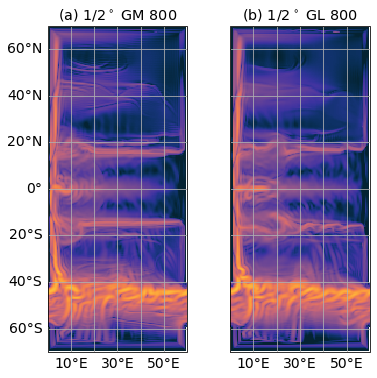

In [12]:
exps = [
    exps_param['nw2_0.5deg_N15_KHTH800'],
    exps_param['nw2_0.5deg_N15_KHGL800_hbbl5'],
]
abc_list = ['(a)', '(b)']

fig = plot_KE(exps, abc_list, 1, 2, plot_colorbar=False)
figname = '/glade/u/home/noraloose/GL90_paper/figures/KE_0.5deg.png' 
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/4 degree

In [13]:
v = exps_param['nw2_0.25deg_N15_KHGL300_hbbl5']
v['label'] = r'$1/4^\circ$ GL 300'
v = exps_param['nw2_0.25deg_N15_KHGL800_hbbl5']
v['label'] = r'$1/4^\circ$ GL 800'

Time: 32500
Time: 77000
Time: 77000
Time: 77000
Time: 77000


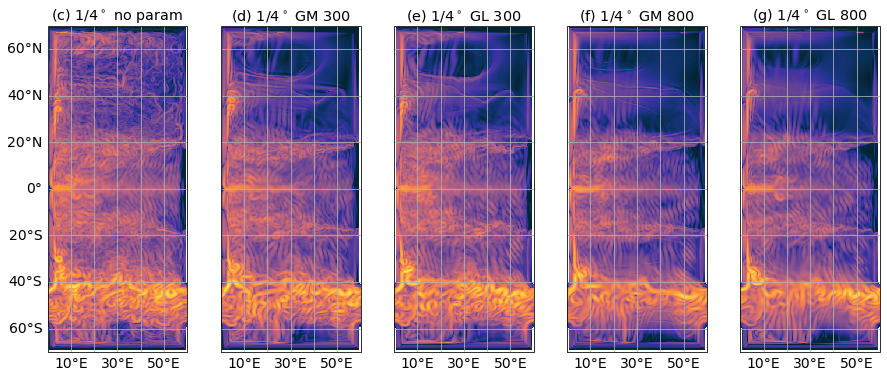

In [14]:
exps = [
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20'],
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHTH800'],
    exps_param['nw2_0.25deg_N15_KHGL800_hbbl5'],
]
abc_list = ['(c)', '(d)', '(e)', '(f)', '(g)']

fig = plot_KE(exps, abc_list, 1, 5, plot_colorbar=False)
figname = '/glade/u/home/noraloose/GL90_paper/figures/KE_0.25deg.png' 
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/8 degree

In [15]:
v = exps_param['nw2_0.125deg_N15_KHGL100_hbbl5']
v['label'] = r'$1/8^\circ$ GL 100'
v = exps_param['nw2_0.125deg_N15_KHGL800_hbbl5']
v['label'] = r'$1/8^\circ$ GL 800'

Time: 6500
Time: 28000
Time: 28000
Time: 28000
Time: 28000


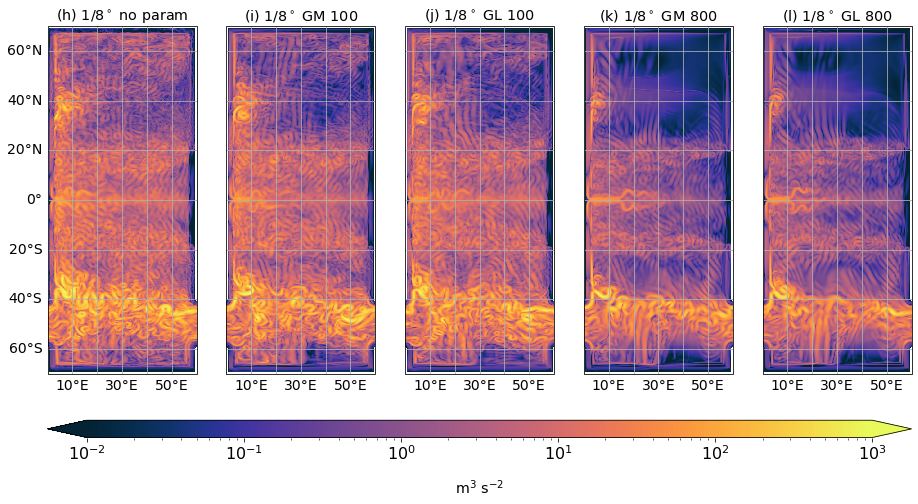

In [16]:
exps = [
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20'],
    exps_param['nw2_0.125deg_N15_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHGL100_hbbl5'],
    exps_param['nw2_0.125deg_N15_KHTH800'],
    exps_param['nw2_0.125deg_N15_KHGL800_hbbl5'],
]
abc_list = ['(h)', '(i)', '(j)', '(k)', '(l)']

fig = plot_KE(exps, abc_list, 1, 5)

figname = '/glade/u/home/noraloose/GL90_paper/figures/KE_0.125deg.png' 
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)